In [5]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline

create_profiling = False

In [6]:
data = pd.read_csv('E:/Users/Vipin/Documents/BHT/CalgoLab/RIWWER/data/vierlinden_21_22_23_all.csv', sep=',')

if create_profiling:
    profile = ProfileReport(data, title='Vierlinden 2021 - 2023', explorative=True)
    profile.to_file('../data_profilings/Vierlinden_Profiling_Report_21_22_23.html')
else:
    print('No Profling Report created')

No Profling Report created


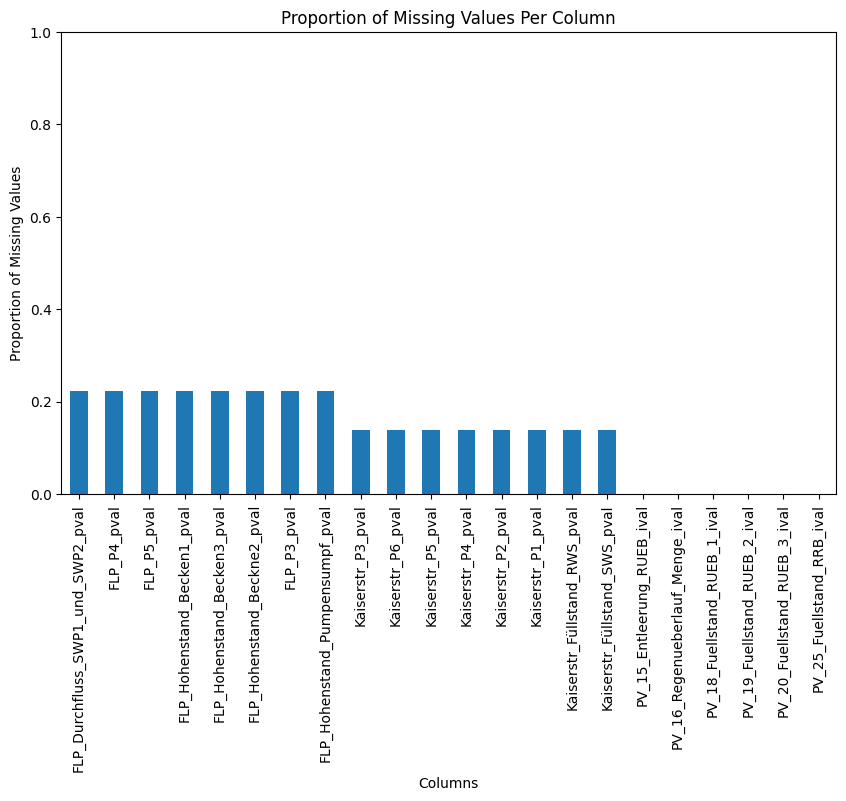

In [7]:
data = pd.read_csv('E:/Users/Vipin/Documents/BHT/CalgoLab/RIWWER/data/vierlinden_21_22_23_all.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Calculate the proportion of missing values per column
missing_proportions = data.isnull().mean()  # mean() calculates the proportion of NaNs

# Filter out columns that have no missing values
missing_proportions = missing_proportions[missing_proportions > 0]

# Sort the series for better visualization
missing_proportions.sort_values(ascending = False, inplace = True)

# Create a bar plot
plt.figure(figsize=(10, 6))
missing_proportions.plot(kind='bar')

# Adding titles and labels
plt.title('Proportion of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Proportion of Missing Values')

# Set the y-axis to range from 0 to 1
plt.ylim(0, 1)

# Show the plot
plt.show()

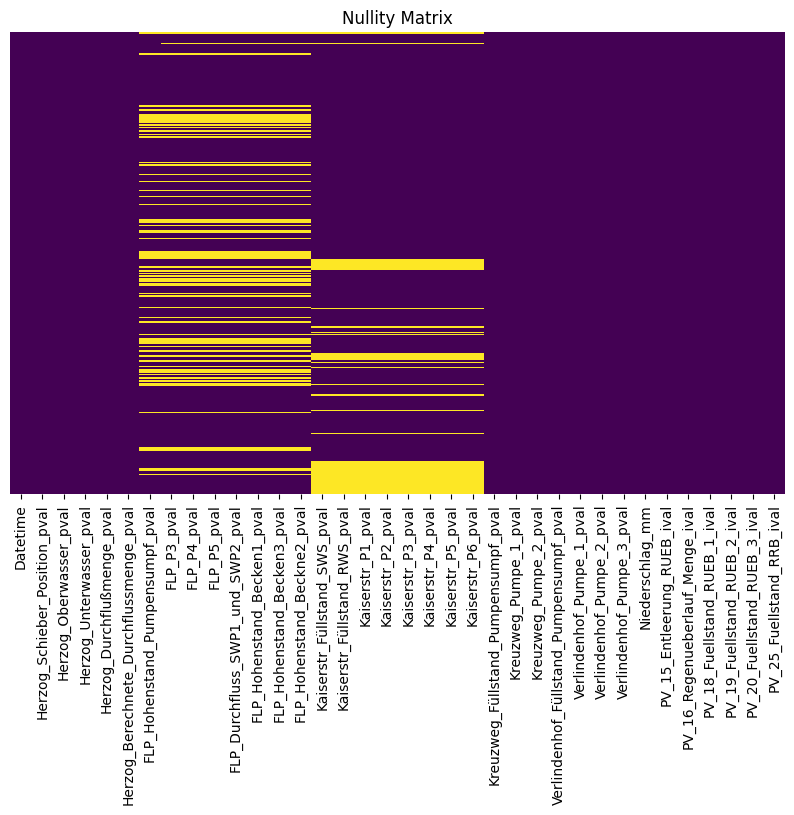

In [19]:
# Create a dataframe indicating where data is missing
missing = data.isnull()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap to visualize the missing data
sns.heatmap(missing, cbar=False, yticklabels=False, cmap='viridis')

# Optional: customize the plot, e.g., setting a title
plt.title('Nullity Matrix')

# Show the plot
plt.show()

We see that at the beginning of the time series data we have many NaNs in the sensory data.
So I will remove the first rows that contain NaNs since we still we still will have a continuous time series.

In fact the first 3 days (until 2021-01-04 06:00:00) have missing sensory data.

In [ ]:
# Find the first index where all columns have non-missing data
first_valid_index = data_with_removed_highnans.dropna().index[0]
print('The date of the first complete row is: {}'.format(data_with_removed_highnans.loc[first_valid_index, 'Datetime']))

trimmed_data = data_with_removed_highnans.loc[first_valid_index:, :]

# Create a dataframe indicating where data is missing
missing = trimmed_data.isnull()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap to visualize the missing data
sns.heatmap(missing, cbar=False, yticklabels=False, cmap='viridis')

# Optional: customize the plot, e.g., setting a title
plt.title('Nullity Matrix')

# Show the plot
plt.show()

Now there are a couple of occurences in the middle where we have missing sensory data.
To not lose the continuity of the time series I will fill these gaps with linear interpolation.

In [ ]:
# Impute the missing values using linear interpolation
# For this it is important that the timeseries is evenly spaced
complete_data = trimmed_data.interpolate(method='linear')
complete_data['Datetime'] = pd.to_datetime(complete_data['Datetime'])

# Save the complete data to a csv file
complete_data.to_csv('../../data/Vierlinden/Vierlinden_2021_Complete.csv', index=False)

In [ ]:
if create_profiling:
    profile = ProfileReport(complete_data, title='Vierlinden 2021 Complete Data', explorative=True)
    profile.to_file('../data_profilings/Vierlinden_Profiling_Report_No_NaNs.html')
else:
    print('No Profling Report created')

Now that the missing values are imputed we can focus on feature engineering.

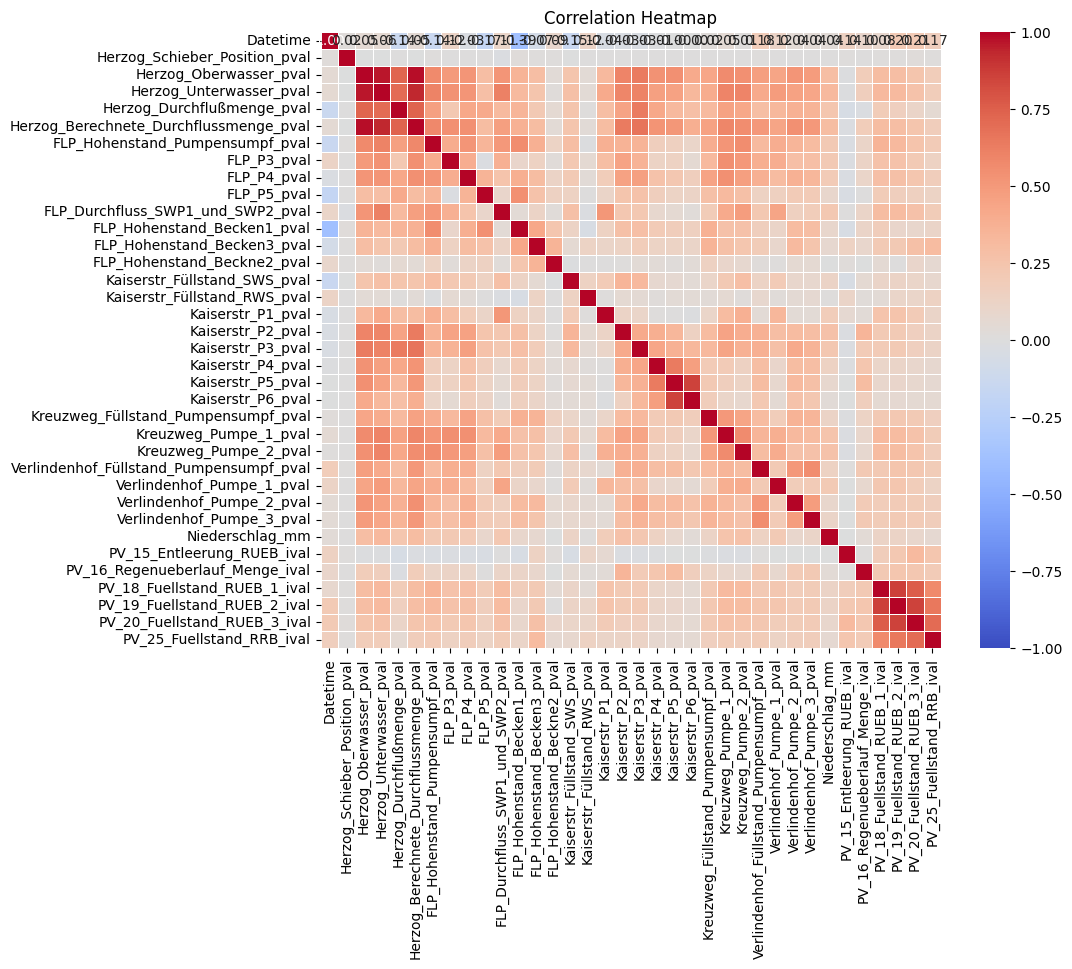

In [22]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmin=-1, vmax=1)

# Add titles and labels if needed
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Use linear regression first to evaluate linear importance of the features
X = complete_data.drop(['Datetime', 
                        'Füllstand_RRB', 
                        'Entleerung_RüB', 
                        'Füllstand_RüB_1', 
                        'Füllstand_RüB_2', 
                        'Füllstand_RüB_3',
                        'Kreuzweg_outflow [l/s]',
                        'Kaiserstr_outflow [l/s]'], 
                       axis=1)
y1 = complete_data['Kreuzweg_outflow [l/s]']
y2 = complete_data['Kaiserstr_outflow [l/s]']

# Split the data into training and test sets
train_size = int(len(complete_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y1_train, y1_test = y1[:train_size], y1[train_size:]
y2_train, y2_test = y2[:train_size], y2[train_size:]

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model1 = LinearRegression()
model2 = LinearRegression()
model1.fit(X_train, y1_train)
model2.fit(X_train, y2_train)

# Evaluate model1
print('Model 1 fitted for Kreuzweg:')
y_pred = model1.predict(X_test)
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y1_test, y_pred)))

# Feature importance through the coefficiencts for m1
importance1 = pd.DataFrame({'Feature': X.columns, 'Coefficient': model1.coef_})\
                        .assign(Absolute_Coefficient=lambda df: df['Coefficient'].abs())\
                        .sort_values(by='Absolute_Coefficient', ascending=False)\
                        .reset_index(drop=True)
print("Feature importance through the coefficients:")
display(importance1[['Feature', 'Coefficient']])

# Evaluate model2
print('\nModel 2 fitted for Kaiserstr:')
y_pred = model2.predict(X_test)
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y2_test, y_pred)))

# Feature importance through the coefficiencts for m2
importance2 = pd.DataFrame({'Feature': X.columns, 'Coefficient': model2.coef_})\
                        .assign(Absolute_Coefficient=lambda df: df['Coefficient'].abs())\
                        .sort_values(by='Absolute_Coefficient', ascending=False)\
                        .reset_index(drop=True)
print("Feature importance through the coefficients:")
display(importance2[['Feature', 'Coefficient']])